# Investigation of Station Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

print('[%s] Complete!' % datetime.datetime.now().time())


[17:07:23.632421] Loading Trip Data...
		[17:07:24.424409] finished chunk 1 of 100
		[17:07:25.241825] finished chunk 10 of 100
		[17:07:26.082383] finished chunk 20 of 100
		[17:07:26.948053] finished chunk 30 of 100
		[17:07:27.831154] finished chunk 40 of 100
		[17:07:28.715462] finished chunk 50 of 100
		[17:07:29.599339] finished chunk 60 of 100
		[17:07:30.502467] finished chunk 70 of 100
		[17:07:31.344649] finished chunk 80 of 100
		[17:07:32.196630] finished chunk 90 of 100
		[17:07:33.065505] finished chunk 100 of 100
[17:07:33.748948] Complete!


In [4]:
trips_df.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


## Utility Functions

In [5]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [6]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Cleanup
<p>Prune to only Commuter Trips, in all regions</p>

<ul>
    <li>user_type : subscriber</li>
    <li>start and end times are between 7am and 10am, or between 4pm and 7pm</li>
</ul>

In [7]:
subscriber_trips_df = trips_df[trips_df.user_type == 'Subscriber']

morning_commuter_trips_df = subscriber_trips_df[(subscriber_trips_df.start_date.dt.hour >= 7) & (subscriber_trips_df.start_date.dt.hour < 10) & (subscriber_trips_df.start_date.dt.dayofweek < 5)]
evening_commuter_trips_df = subscriber_trips_df[(subscriber_trips_df.start_date.dt.hour >= 16) & (subscriber_trips_df.start_date.dt.hour < 19) & (subscriber_trips_df.start_date.dt.dayofweek < 5)]

commuter_trips_df = pd.concat([morning_commuter_trips_df, evening_commuter_trips_df])
commuter_trips_df.reset_index(inplace=True, drop=True)
commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [8]:
commuter_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548223 entries, 0 to 548222
Data columns (total 23 columns):
trip_id               548223 non-null int64
duration              548223 non-null int64
start_date            548223 non-null datetime64[ns]
start_station_name    548223 non-null object
start_terminal        548223 non-null int64
end_date              548223 non-null datetime64[ns]
end_station_name      548223 non-null object
end_terminal          548223 non-null int64
bike_id               548223 non-null int64
user_type             548223 non-null category
user_zip              548223 non-null int64
duration_minutes      548223 non-null float64
start_zip             548223 non-null int64
end_zip               548223 non-null int64
max_temp              548197 non-null float64
mean_temp             548197 non-null float64
min_temp              548197 non-null float64
max_wind              548223 non-null float64
mean_wind             548223 non-null float64
max_gust          

## Analysis 1 - Explore Station Usage
<p>Find Most Start and End Terminals</p>
<p></p>
<p></p>

In [9]:
popular_stations_df = pd.DataFrame()

# count trips starting at each terminal 
popular_stations_df = commuter_trips_df.groupby('start_terminal')['trip_id'].count().to_frame()
popular_stations_df.columns = ['start_count']

# calculate share of all trip starts for each terminal
popular_stations_df['start_trip_share'] = popular_stations_df['start_count'] / popular_stations_df['start_count'].sum() * 100.

# count trips ending at each terminal
popular_stations_df['end_count'] = commuter_trips_df.groupby('end_terminal')['trip_id'].count().to_frame()

# calculate share of all trip ends for each terminal
popular_stations_df['end_trip_share'] = popular_stations_df['end_count'] / popular_stations_df['end_count'].sum() * 100.

# set index to terminal id
popular_stations_df.index.name = 'terminal_id'
popular_stations_df.head()

,start_count,start_trip_share,end_count,end_trip_share
terminal_id,,,,
2,9273,1.691465,9252,1.687634
3,346,0.063113,597,0.108897
4,2994,0.546128,2909,0.530623
5,973,0.177483,945,0.172375
6,1671,0.304803,1933,0.352594


# Graphical EDA of Start and End Terminal Trip Counts by Region

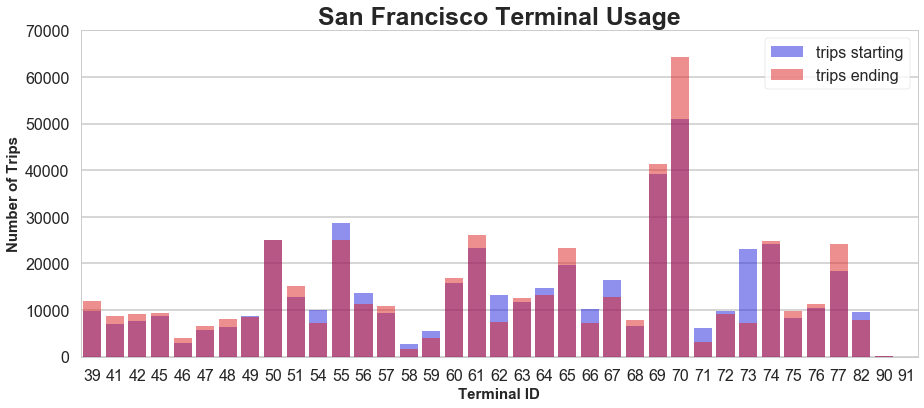

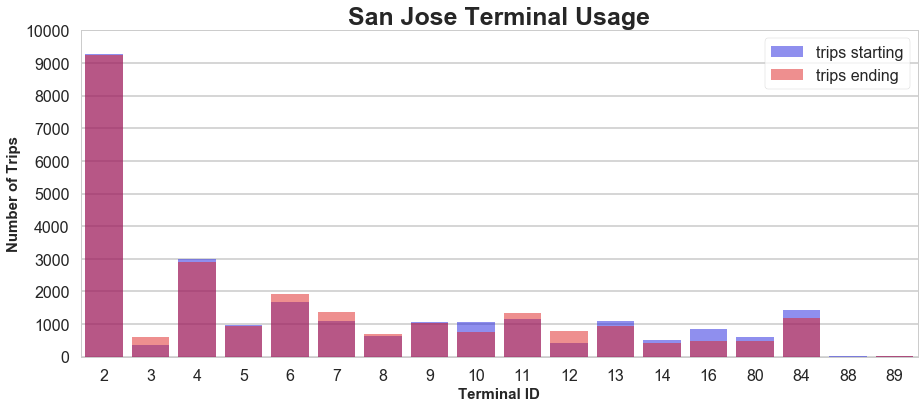

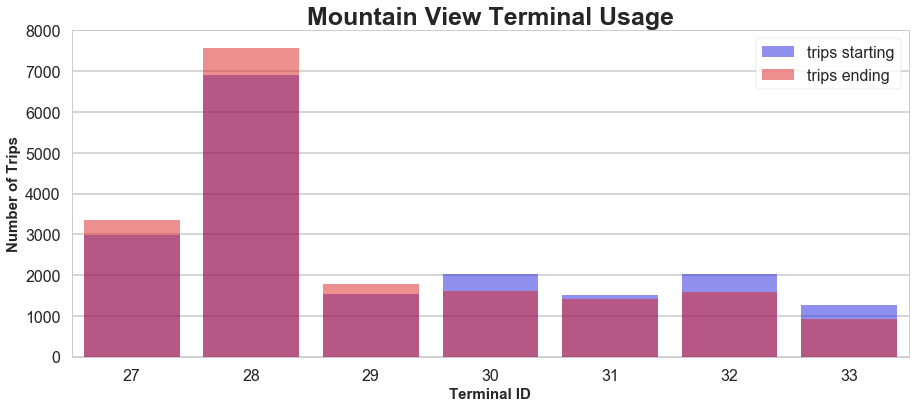

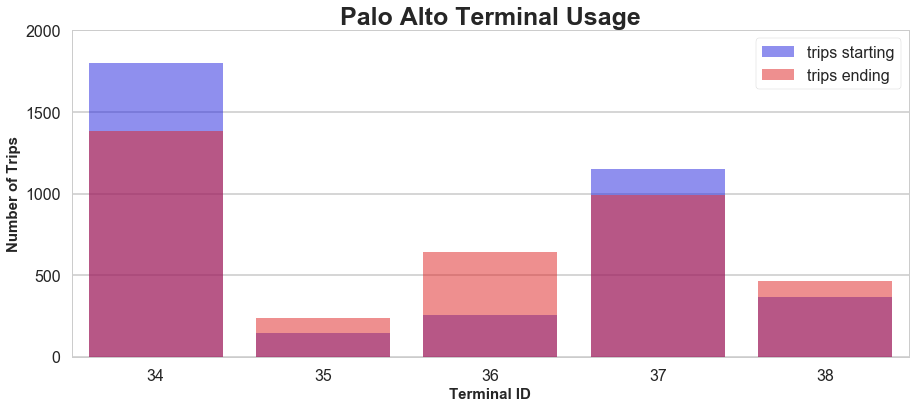

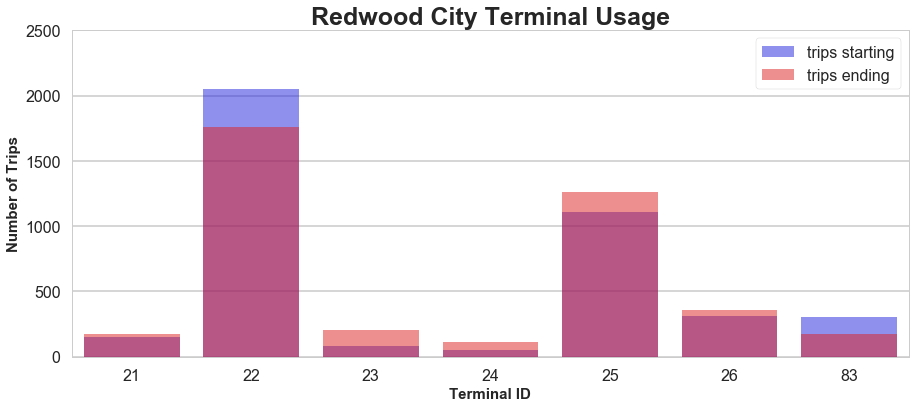

In [32]:
top_start_stations_in_region = {}
top_end_stations_in_region = {}

for zip_code in ordered_zipcodes:
    
    df = pd.DataFrame()
    
    tmp = commuter_trips_df[(commuter_trips_df.start_zip == zip_code) & (commuter_trips_df.end_zip == zip_code)]

    df = tmp.groupby('start_terminal')['trip_id'].count().to_frame()
    df.columns = ['start_count']

    df['start_share'] = popular_stations_df['start_count'] / df['start_count'].sum() * 100.
    df['end_count'] = tmp.groupby('end_terminal')['trip_id'].count().to_frame()
    
    df['end_share'] = popular_stations_df['end_count'] / df['end_count'].sum() * 100.
    
    df.index.name = 'terminal_id'
    
    # append top n to top_stations_in_region
    top_start_stations_in_region[zip_to_landmark(zip_code)] = list(df.sort_values(['start_share'], ascending=False)['start_share'].index)
    top_end_stations_in_region[zip_to_landmark(zip_code)] = list(df.sort_values(['end_share'], ascending=False)['end_share'].index)
    
    plt.subplots(figsize=(15,6))

    ax = sns.barplot(x=df.index, y = 'start_count', data=df, color='b', alpha=0.5, label='trips starting')
    sns.barplot(x=df.index, y = 'end_count', data=df, color='r', alpha=0.5, label='trips ending', ax=ax)

    title = '%s Terminal Usage' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Terminal ID', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    # set y axis
    y_interval = df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 10000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 500

    y_max = -np.inf
    y_max = df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.legend(loc=1, frameon=True)
        
    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

## Graphical EDA of Start and End Terminal Trip Counts by Region - Day Count Adjusted

## Load Station Data

In [33]:
print('[%s] Loading Status Data...' % datetime.datetime.now().time())

station_df = pd.DataFrame()
station_file = '../clean_data/bayareabikeshare/station_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(station_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(station_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['first_service_date', 'last_service_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

station_df = pd.concat(chunks)

print('[%s] Complete!' % datetime.datetime.now().time())

[17:16:47.284824] Loading Status Data...
		[17:16:47.293785] finished chunk 1 of 1
[17:16:47.298027] Complete!


In [34]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 10 columns):
station_id            79 non-null int64
name                  79 non-null object
lat                   79 non-null float64
long                  79 non-null float64
dock_count            79 non-null int64
landmark              79 non-null object
first_service_date    79 non-null datetime64[ns]
last_service_date     79 non-null datetime64[ns]
zip_code              79 non-null int64
days_in_service       79 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 6.8+ KB


In [35]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098


# Station Data with appeneded start and end trip counts

In [36]:
def weekdays_in_service(row):
    return pd.date_range(start=row.first_service_date, end=row.last_service_date, freq='B').shape[0]

In [37]:
station_df['commuter_days'] = station_df.apply(lambda row: weekdays_in_service (row), axis=1)

In [38]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,785
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,785
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,785
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,785
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,785


In [39]:
def trips_per_day(row, trips_df=None, which=''):
    '''Get numebr of trips started or ended at each terminal between terminals first and last day of service only'''
    terminal_id = row.station_id
    terminal_first_service_date = row.first_service_date
    terminal_last_service_date  = row.last_service_date
    
    if which == 'start':
        tmp = trips_df[(trips_df.start_terminal == terminal_id) & (trips_df.start_date >= terminal_first_service_date) 
                       & (trips_df.start_date < terminal_last_service_date)]
        return tmp.shape[0]
    if which == 'end':
        tmp = trips_df[(trips_df.end_terminal == terminal_id) & (trips_df.start_date >= terminal_first_service_date) 
                       & (trips_df.start_date < terminal_last_service_date)]
        return tmp.shape[0]

In [40]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=commuter_trips_df, which='start'), axis=1)
station_df['commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=commuter_trips_df, which='end'), axis=1)

# append data from all trips
station_df['start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=trips_df, which='start'), axis=1)
station_df['end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=trips_df, which='end'), axis=1)

In [41]:
# Calculate Trips per day
station_df['commuter_trip_starts_per_day'] = station_df['commuter_start_trip_count'] / station_df['commuter_days']
station_df['commuter_trip_ends_per_day']   = station_df['commuter_end_trip_count'] / station_df['commuter_days']

station_df['trip_starts_per_day'] = station_df['start_trip_count'] / station_df['days_in_service']
station_df['trip_ends_per_day']   = station_df['end_trip_count'] / station_df['days_in_service']

In [43]:
station_df.tail()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
74,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2016-08-31,95113,875,626,1423,1185,2554,2298,2.273163,1.892971,2.918857,2.626286
75,88,5th S. at E. San Salvador St,37.331957,-121.881630,19,San Jose,2016-07-05,2016-08-31,95113,57,42,3,3,8,5,0.071429,0.071429,0.140351,0.087719
76,89,S. Market st at Park Ave,37.332398,-121.890429,19,San Jose,2016-07-05,2016-08-31,95113,57,42,10,10,70,91,0.238095,0.238095,1.228070,1.596491
77,90,5th St at Folsom St,37.780148,-122.403158,31,San Francisco,2016-08-04,2016-08-31,94107,27,20,70,77,167,141,3.500000,3.850000,6.185185,5.222222
78,91,Cyril Magnin St at Ellis St,37.785908,-122.408891,35,San Francisco,2016-08-04,2016-08-31,94107,27,20,13,9,57,54,0.650000,0.450000,2.111111,2.000000


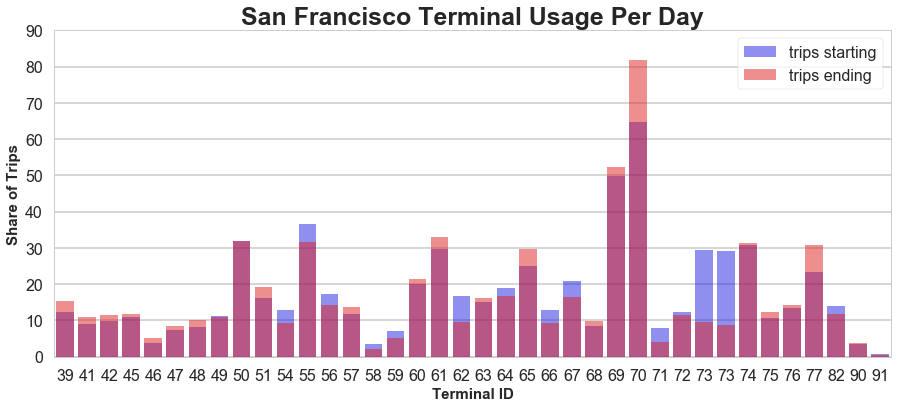

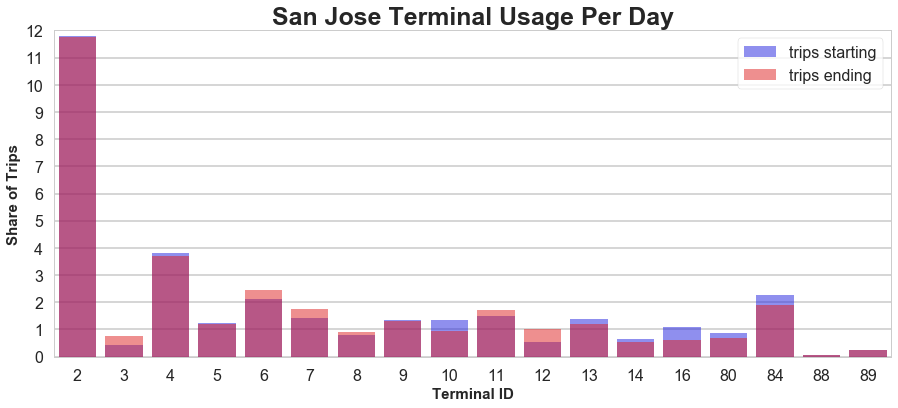

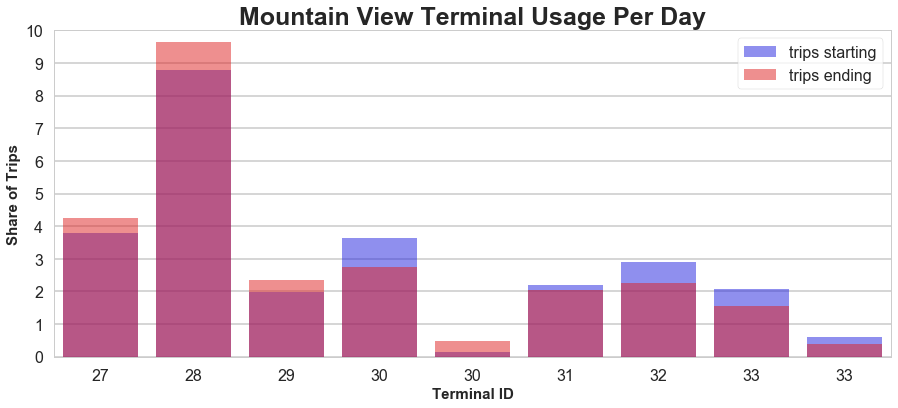

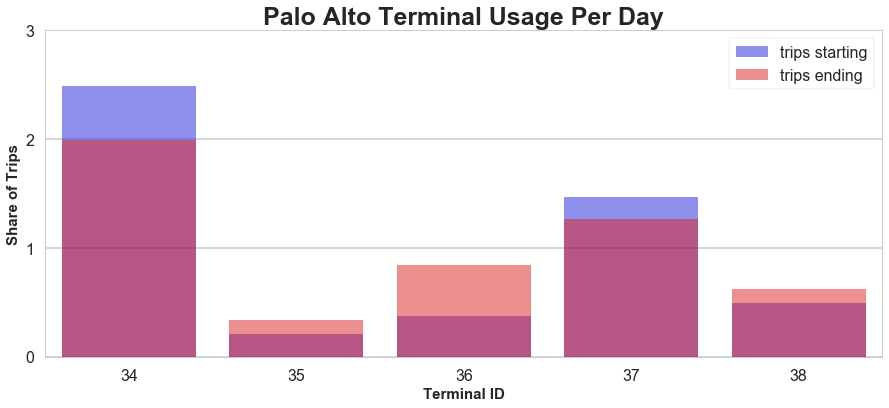

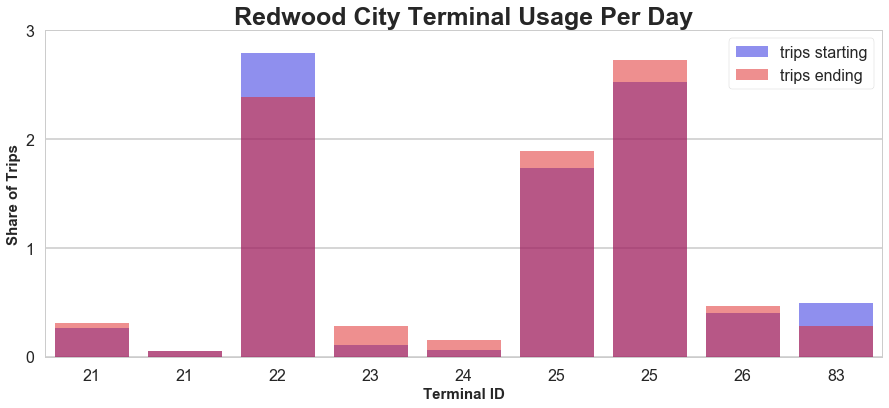

In [54]:
for zip_code in ordered_zipcodes:
    
    df = station_df[(station_df.zip_code == zip_code)]
    
    

    plt.subplots(figsize=(15,6))

    ax = sns.barplot(x=df.index, y = 'commuter_trip_starts_per_day', data=df, color='b', alpha=0.5, label='trips starting')
    sns.barplot(x=df.index, y = 'commuter_trip_ends_per_day', data=df, color='r', alpha=0.5, label='trips ending', ax=ax)

    
    ax.set_xticklabels(df.station_id)
    
    title = '%s Terminal Usage Per Day' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Terminal ID', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    
    y_max = -np.inf
    y_max = df['commuter_trip_ends_per_day'].max()
    
    if df['commuter_trip_starts_per_day'].max() > y_max:
        df['commuter_trip_ends_per_day'].max()
    
    y_interval = y_max/10
    
    if y_interval > 4:
        y_interval = 10
    elif y_interval < 4 and y_interval > 3:
        y_interval = 5
    else:
        y_interval = 1

    y_max = math.ceil(y_max/y_interval) * y_interval
    
    if y_max == 2:
        y_max = 3
        
    ax.set_ylim([0, y_max])
    
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Share of Trips', size=LABEL_FONT_SIZE, weight='bold')
    ax.legend(loc=1, frameon=True)
        
    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Identify Popular  Commuter Routes
<p> A Route is a trip from Terminal A to Terminal B</p>

In [83]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,785,9250,9238,13417,13149,11.783439,11.768153,12.219490,11.975410
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,785,345,596,1809,2101,0.439490,0.759236,1.647541,1.913479
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,785,2991,2902,5157,5017,3.810191,3.696815,4.696721,4.569217
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,785,971,944,1969,1841,1.236943,1.202548,1.793260,1.676685
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,785,1668,1931,3977,4337,2.124841,2.459873,3.622040,3.949909


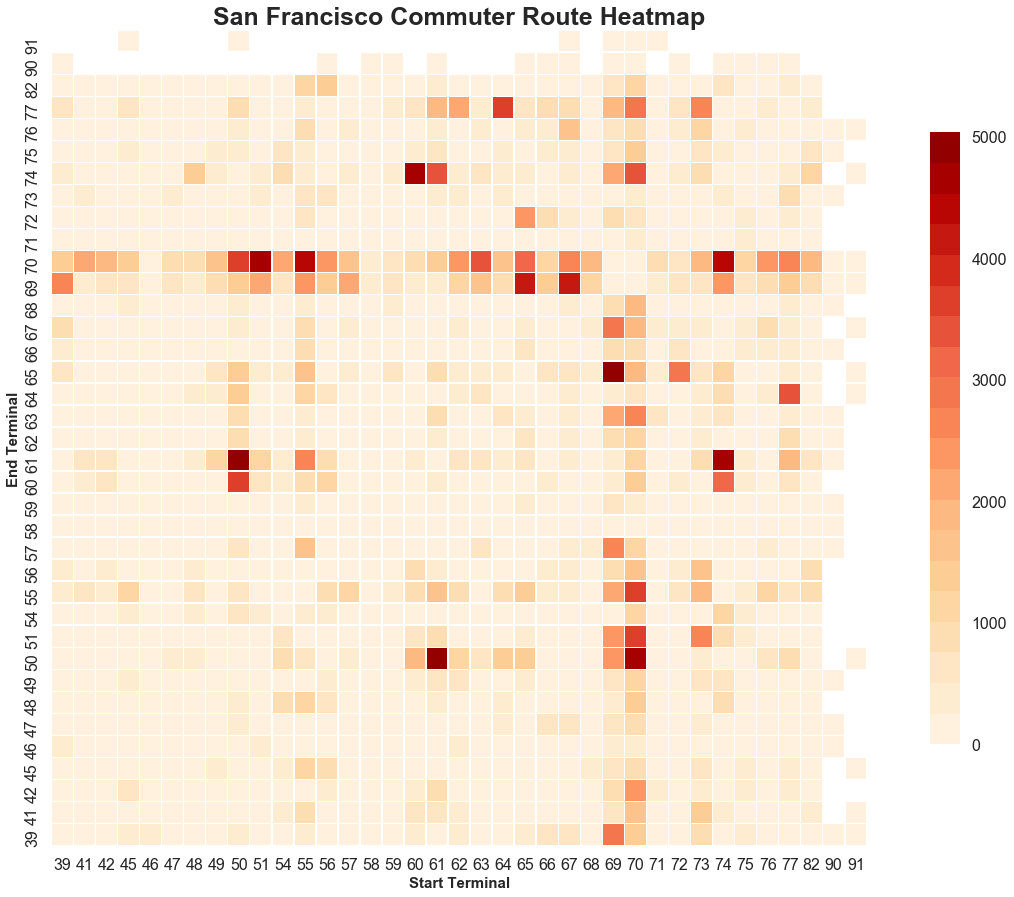

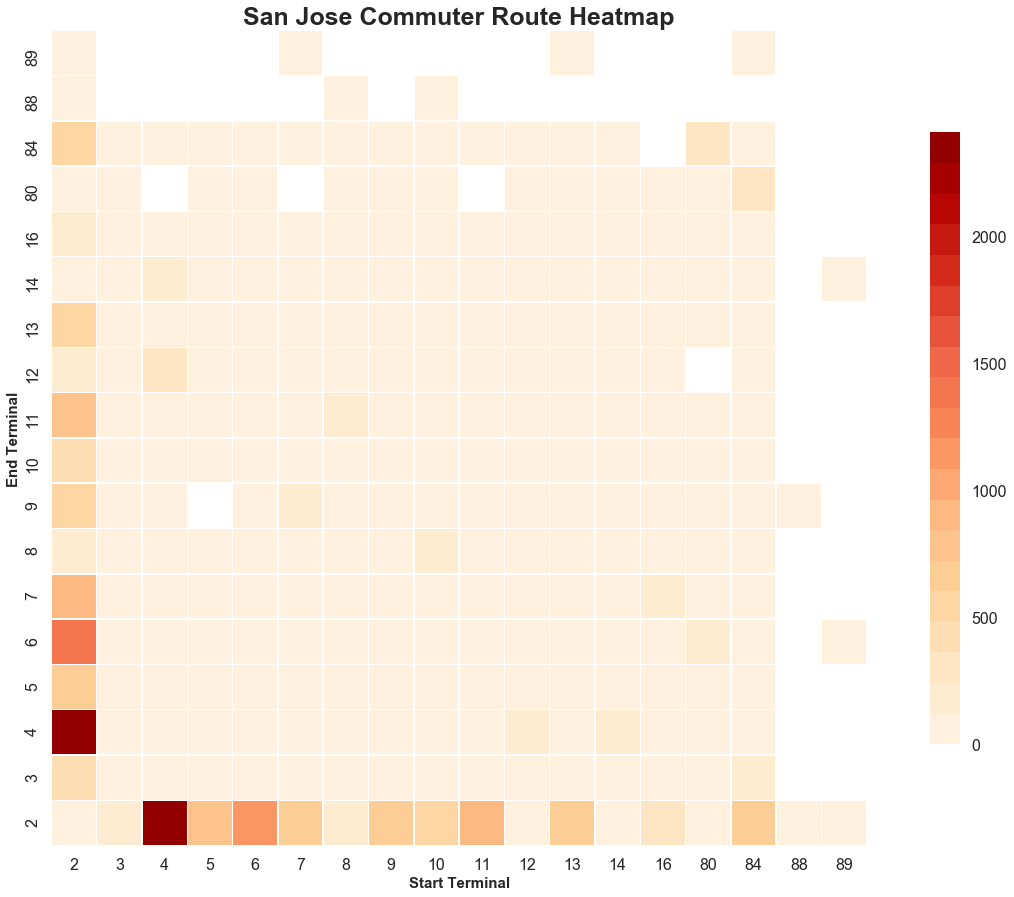

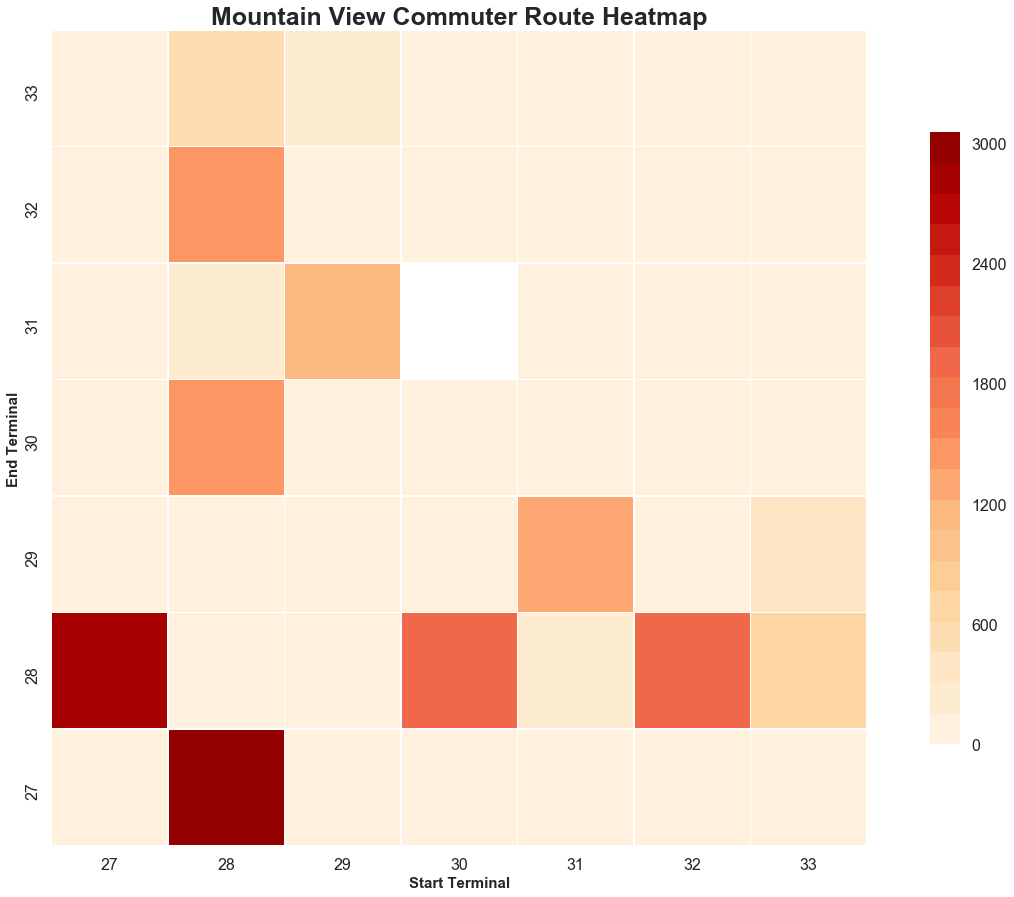

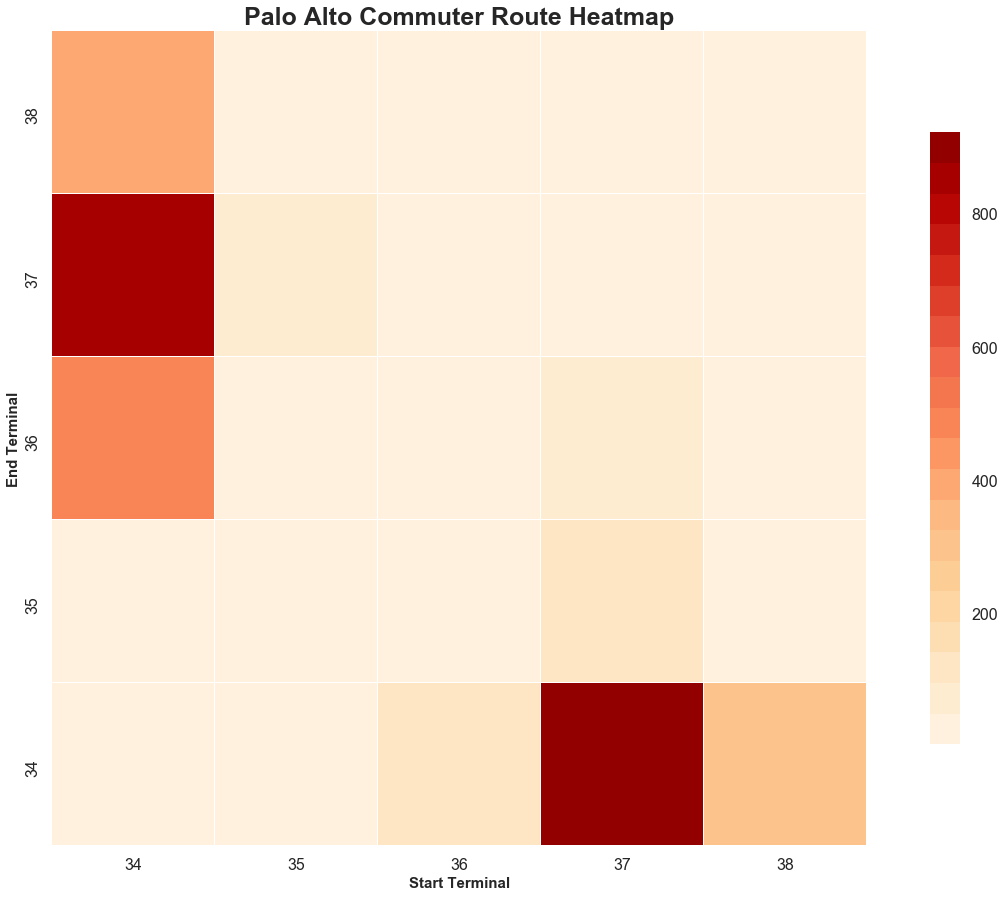

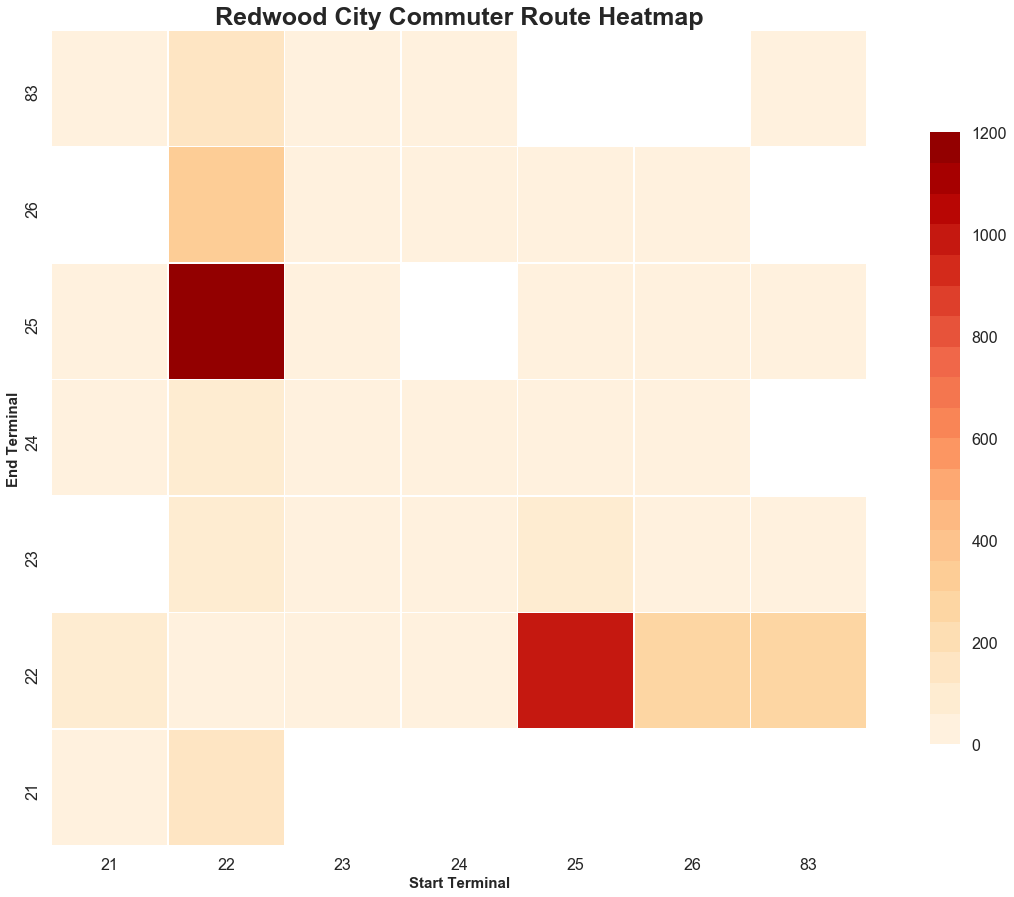

In [81]:
for zip_code in ordered_zipcodes:
    
    zip_stations = sorted(pd.unique(station_df[station_df.zip_code == zip_code]['station_id']))
    
    index   = [x for x in zip_stations]
    columns = [x for x in zip_stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    
    # create grid of trips from start to end terminal counts
    for sid in zip_stations:
        for eid in zip_stations:
            # count trips between terminals
            route_trip_count = commuter_trips_df[(commuter_trips_df.start_terminal == sid) & (commuter_trips_df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]
    
    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)
    
    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))
    
    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)
    
    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    
    title = '%s Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

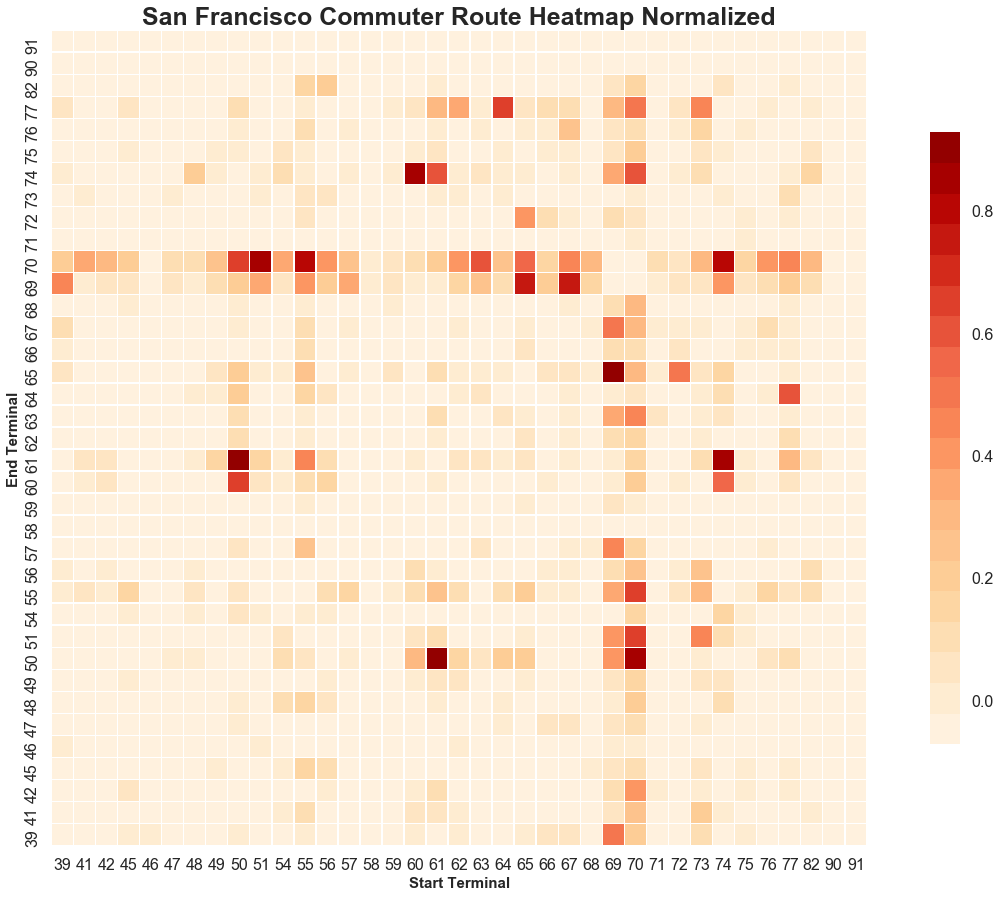

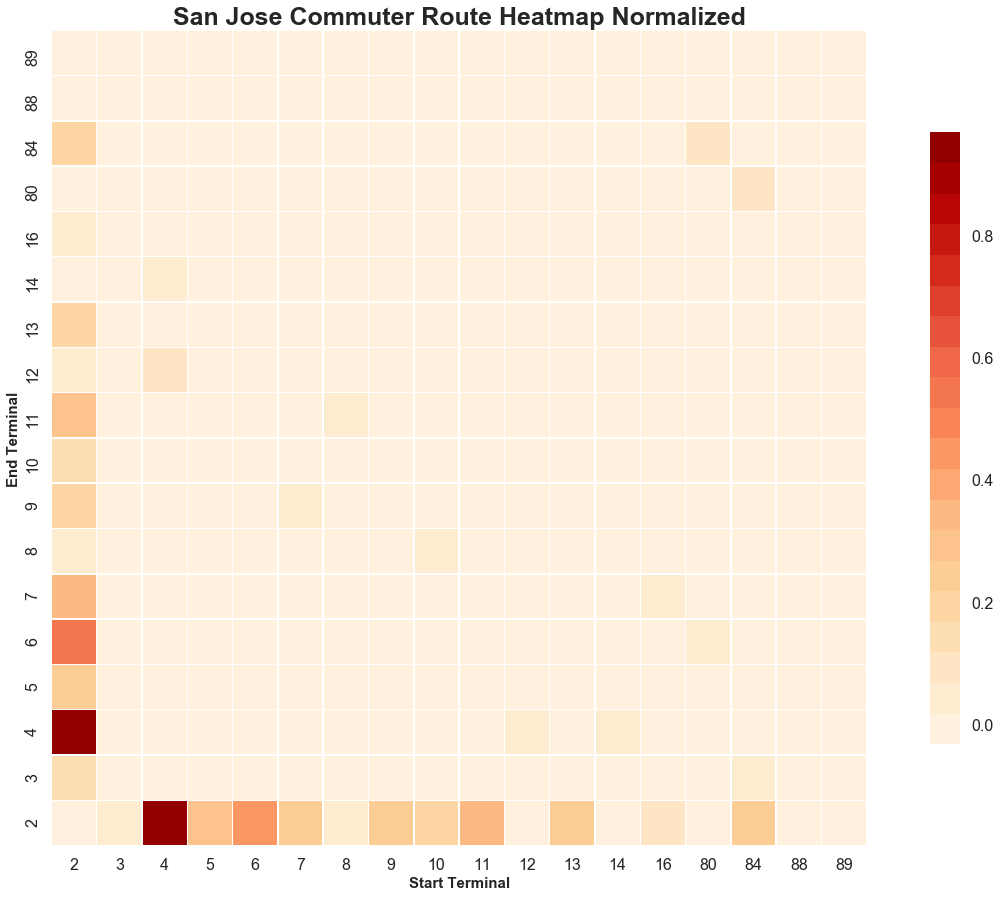

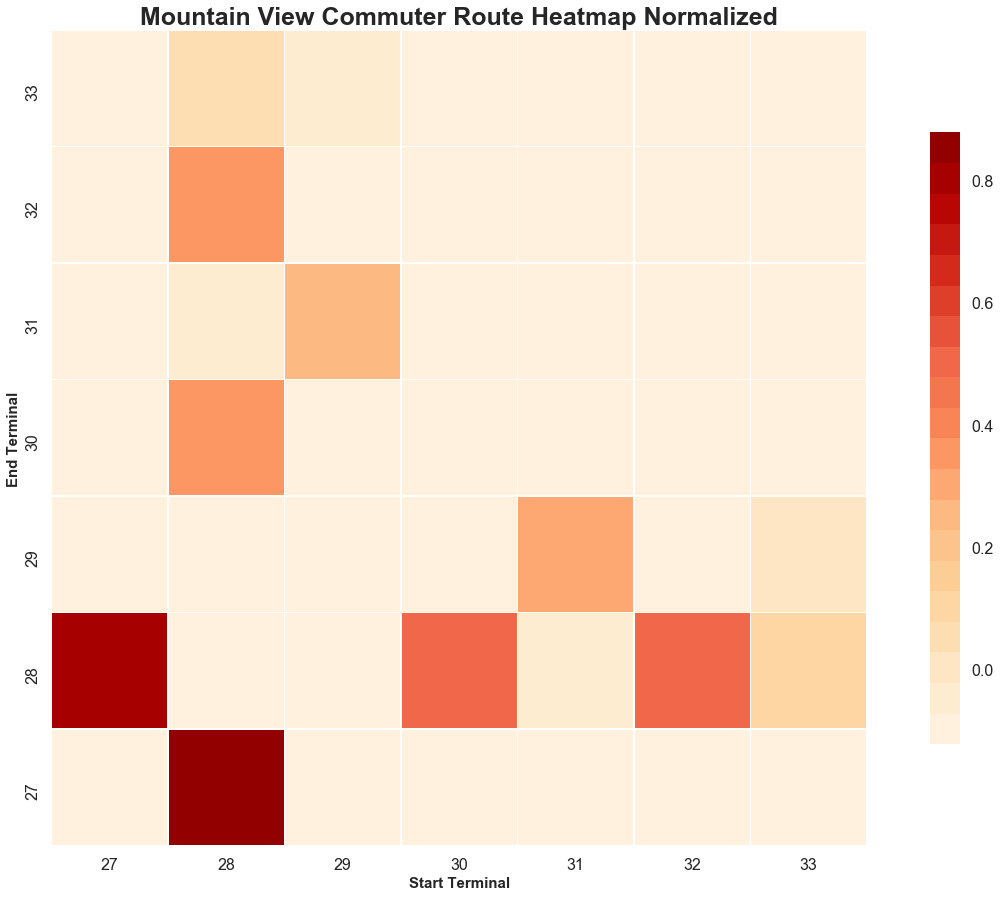

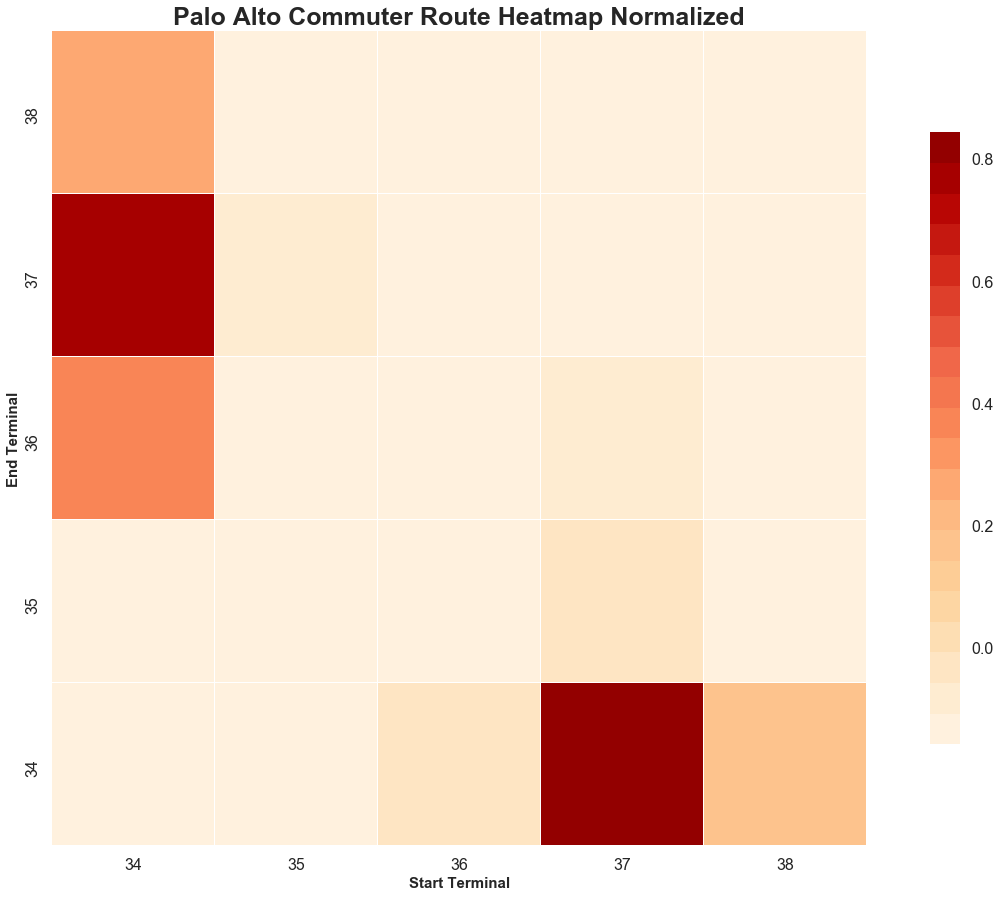

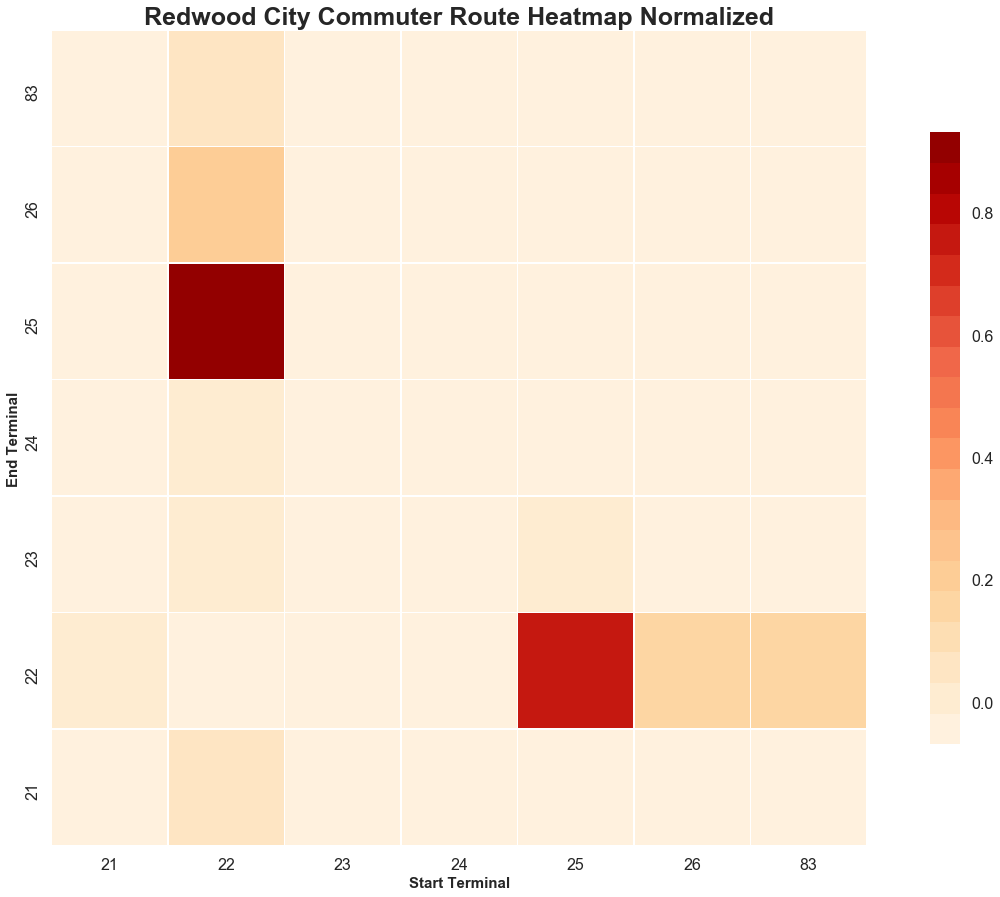

In [82]:
for zip_code in ordered_zipcodes:
    
    zip_stations = sorted(pd.unique(station_df[station_df.zip_code == zip_code]['station_id']))
    
    index   = [x for x in zip_stations]
    columns = [x for x in zip_stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    
    # create grid of trips from start to end terminal counts
    for sid in zip_stations:
        for eid in zip_stations:
            # count trips between terminals
            route_trip_count = commuter_trips_df[(commuter_trips_df.start_terminal == sid) & (commuter_trips_df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]
    
    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)
    
    # normalize trip grid    
    trip_grid = (trip_grid - trip_grid.mean().mean()) / (trip_grid.max().max() - trip_grid.min().min())

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))
    
    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)
    
    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    
    title = '%s Commuter Route Heatmap Normalized' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Identify Top Start and End Stations Used by Commuters

In [87]:
station_df.head(3)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,785,9250,9238,13417,13149,11.783439,11.768153,12.219490,11.975410
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,785,345,596,1809,2101,0.439490,0.759236,1.647541,1.913479
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,785,2991,2902,5157,5017,3.810191,3.696815,4.696721,4.569217


In [129]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Commuter Start Terminals by Total Trip Count')
    print('\tID - Trips - Trip Share - Name')
    for i, sid in enumerate(top_stations):
#         print('\t%s - %s - %2.4f - %s' % (sid, df_trip_count[i], df_trip_count[i]/sum(df_trip_count)*100.,  df_station_name[i]))
        print('\t%s - %s - %s - %s' % (sid, df_trip_count[i], str(df_trip_count[i]/sum(df_trip_count)*100.)[:7].rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Commuter End Terminals by Total Trip Count')
    print('\tID - Trips - Trip Share - Name')
    for i, sid in enumerate(top_stations):
#         print('\t%s - %s - %2.4f - %s' % (sid, df_trip_count[i], df_trip_count[i]/sum(df_trip_count)*100.,  df_station_name[i]))
        print('\t%s - %s - %s - %s' % (sid, df_trip_count[i], str(df_trip_count[i]/sum(df_trip_count)*100.)[:7].rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Commuter Start Terminals by Total Trip Count
	ID - Trips - Trip Share - Name
	70 - 50851 - 19.4463 - San Francisco Caltrain (Townsend at 4th)
	69 - 39212 - 14.9953 - San Francisco Caltrain 2 (330 Townsend)
	55 - 28705 - 10.9773 - Temporary Transbay Terminal (Howard at Beale)
	50 - 25013 - 9.56542 - Harry Bridges Plaza (Ferry Building)
	74 - 24229 - 9.26560 - Steuart at Market
	61 - 23234 - 8.88509 - 2nd at Townsend
	65 - 19640 - 7.51068 - Townsend at 7th
	77 - 18398 - 7.03572 - Market at Sansome
	67 - 16446 - 6.28924 - Market at 10th
	60 - 15766 - 6.02920 - Embarcadero at Sansome

Top Commuter End Terminals by Total Trip Count
	ID - Trips - Trip Share - Name
	70 - 64257 - 22.5136 - San Francisco Caltrain (Townsend at 4th)
	69 - 41177 - 14.4271 - San Francisco Caltrain 2 (330 Townsend)
	61 - 25985 - 9.10435 - 2nd at Townsend
	50 - 25019 - 8.76589 - Harry Bridges Plaza (Ferry Building)
	55 

# Load Station Status Data - 5m Interval

In [ ]:
print('[%s] Loading Status Data...' % datetime.datetime.now().time())

station_status_df = pd.DataFrame()
station_status_file = '../clean_data/bayareabikeshare/status_data_5m_resampled_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(station_status_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(station_status_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['time']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

station_status_df = pd.concat(chunks)

print('[%s] Complete!' % datetime.datetime.now().time())


In [ ]:
station_status_df.info()

In [ ]:
commuter_trips_df.info()

In [ ]:
# append start station stats at trip start time to trip records
commuter_df = pd.merge(left=commuter_trips_df, right=station_status_df, left_on=['start_date', 'start_terminal'] , right_on=['time', 'station_id'])
commuter_df.rename(columns={'time':'junk',
                            'bikes_available':'start_bikes_available',
                            'docks_available':'start_docks_available',
                            'utilization':'start_utilization'
                           }, inplace=True)
commuter_df.drop(['station_id', 'junk', 'dock_count', 'zip_code'], axis=1, inplace=True)



In [ ]:
commuter_df.info()

In [ ]:
# append end station stats at trip end time to trip records
commuter_df = pd.merge(left=commuter_df, right=station_status_df, left_on=['start_date', 'end_terminal'] , right_on=['time', 'station_id'])
commuter_df.rename(columns={'time':'junk',
                            'bikes_available':'end_bikes_available',
                            'docks_available':'end_docks_available',
                            'utilization':'end_utilization'
                           }, inplace=True)
commuter_df.drop(['station_id', 'junk', 'dock_count', 'zip_code'], axis=1, inplace=True)

In [ ]:
commuter_df.info()

In [ ]:
for col in ['start_station_name','end_station_name','bike_id','user_type','user_zip','duration_minutes','start_zip','end_zip','events']:
    try:
        commuter_df.drop(col, axis=1, inplace=True)
    except:
        pass

for col in ['start_date','end_date']:
    try:
        commuter_df.drop(col, axis=1, inplace=True)
    except:
        pass
    
commuter_df.info()

In [ ]:
commuter_df.set_index('trip_id', inplace=True)
commuter_df.head(5)

# Subscriber Terminal Usage

In [ ]:
station_simple_df.head()

In [ ]:
def make_grids(df, zip_code=-1, station_by='both'):
    '''create grids for heatmaps, outputs 5 grids:
        total_trips_grid
        normalized_total_trips_grid
        daily_mean_trips_grid   -> this is the total number of trips divided by the all days in service for given station
        weekday_mean_trips_grid -> this is the total number of trips divided by the weekday days in service for given station
        weekend_mean_trips_grid -> this is the total number of trips divided by the weekend days in service for given station
        weekend_diff_grid       -> weekday_mean_trips_grid - weekend_mean_trips_grid
        '''
    # if a single zipcode is specified, only plot data for that zipcode
    if zip_code < 5:
        data = df.copy()
    
    # else plot all terminals
    else:
        data = df[df.start_zip == zip_code].copy()
    
    
    weekend_grid = data[data.start_date.dt.dayofweek < 5].groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
    weekday_grid = data[data.start_date.dt.dayofweek >= 5].groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    # plotting station utilization by start terminal only, end terminal only, or the sum of both terminals
    # creates the heatmap grid bu getting a count of trips to each terminal and unstacking the dataframe
    if station_by == 'start':
        grid_set = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    elif station_by == 'end':
        grid_set = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()

    elif station_by == 'both':
        grid_set_A = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()
        grid_set_B = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
        
        grid_set = grid_set_A + grid_set_B
    
    # normalize the grid
    norm_grid     = grid_set/grid_set.max()
        
    # if mapping all stations
    if zip_code < 5:
        # the popularity grid is scaled to mean number of trips per day by dividing the total number of trips by the days the station has been active
        pop_grid = grid_set / station_simple_df['days_in_service']
        pop_grid_weekdays = weekend_grid / station_simple_df['weekday_days_in_service']
        pop_grid_weekends = weekday_grid / station_simple_df['weekend_days_in_service']
    # if mapping only zip code's stations
    else:
        pop_grid = grid_set / station_simple_df[station_simple_df.zip_code == zip_code]['days_in_service']
        pop_grid_weekdays = weekend_grid / station_simple_df[station_simple_df.zip_code == zip_code]['weekday_days_in_service']
        pop_grid_weekends = weekday_grid / station_simple_df[station_simple_df.zip_code == zip_code]['weekend_days_in_service']
    
    # revese grid rows for better visualizations
    grid_set = grid_set.reindex(index=grid_set.index[::-1])
    norm_grid = norm_grid.reindex(index=norm_grid.index[::-1])
    pop_grid = pop_grid.reindex(index=pop_grid.index[::-1])
    pop_grid_weekdays = pop_grid_weekdays.reindex(index=pop_grid_weekdays.index[::-1])
    pop_grid_weekends = pop_grid_weekends.reindex(index=pop_grid_weekends.index[::-1])
    
    weekend_diff_grid = pop_grid_weekdays - pop_grid_weekends
#     weekend_diff_grid = weekend_diff_grid.reindex(index=weekend_diff_grid.index[::-1])
    
    # drop nan rows and columns from pop_grid
    pop_grid.dropna(axis=0, how='all', inplace=True)
    pop_grid.dropna(axis=1, how='all', inplace=True)
#     weekend_diff_grid.dropna(axis=1, how='all', inplace=True)
    
    pop_grid_weekdays.dropna(axis=0, how='all', inplace=True)
    pop_grid_weekdays.dropna(axis=1, how='all', inplace=True)
#     weekend_diff_grid.dropna(axis=1, how='all', inplace=True)
    
    pop_grid_weekends.dropna(axis=0, how='all', inplace=True)
    pop_grid_weekends.dropna(axis=1, how='all', inplace=True)
#     weekend_diff_grid.dropna(axis=1, how='all', inplace=True)
    
    return [grid_set, norm_grid, pop_grid, pop_grid_weekdays, pop_grid_weekends, weekend_diff_grid]

In [ ]:
def plot_grid(grid=None, zip_code=-1, user_type='Subscriber', cmap=None, station_by='both', title_suffix='', annotate=False):
    
    # make all plots the same dimensions, this is scaled to 1.5x width to accoutn for color bar
    plot_size=math.ceil(grid.shape[0]/3)
    if plot_size < 10:
        plot_size = 10

    if grid.shape[0] > 15:
        annotate = False
    
    # adjust width for color bar
    fig = plt.subplots(figsize=(plot_size*1.5, plot_size))
    
    mask = grid.isnull()
    
    # create heatmap for grid
    if annotate:
        try:
            ax = sns.heatmap(grid, linewidths=.5, square=True, cbar=True, cmap=cmap,
                         vmin=0, vmax=grid.max().max(), 
                         mask=mask, annot=True, fmt='d', annot_kws={"size":TICK_FONT_SIZE })
        except:
            ax = sns.heatmap(grid, linewidths=.5, square=True, cbar=True, cmap=cmap,
                         vmin=0, vmax=grid.max().max(), 
                         mask=mask, annot=True, fmt='0.3f', annot_kws={"size":TICK_FONT_SIZE })
    else:
        ax = sns.heatmap(grid, linewidths=.5, square=True, cbar=True, cmap=cmap,
                         vmin=0, vmax=grid.max().max())

    sns.despine()
    
    # Make Title String
    if zip_code < 5:
        title = '%s - Terminal Usage by %s' % (user_type, title_suffix.title())
    else:
        title = '%s - %s Terminal Usage by %s' % (user_type, zip_lookup[zip_code], title_suffix.title())
        
    if station_by != 'both':
        station_by = '%s Terminal' % station_by
        station_by = station_by.title()
        title = title.replace('Terminal', station_by)
    
    # strip white space from title
    title = title.strip()
    
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    
    ax.set_xlabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_xticklabels(grid.columns, size=TICK_FONT_SIZE, rotation=90)

    ax.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_yticklabels(grid.index, size=TICK_FONT_SIZE, rotation=0)    
        
    # write plot to file
    file_name = '../charts/heatmaps/Investigation_' + title.replace(' ', '_').replace('_-_', '_') + '_heatmap.png'
    
    if annotate:
        file_name = file_name.replace('.png', '_annotated.png')
    fig = ax.get_figure()
    fig.savefig(file_name)
    plt.show()


In [ ]:
def plot_trip_heatmap(df, zip_code=-1, user_type='Subscriber', station_by='both', title_suffix='', annotate=False):
    
    # chose color pallet based on user_type
    if user_type == 'Customer':
        cmap = sns.color_palette("OrRd", 20)
    elif user_type == 'Subscriber':
        cmap = sns.color_palette("PuBu", 20)
    else:
        cmap = sns.color_palette("YlGn", 20)
        
    # make various grids from data frame
    trips_grid, trips_norm_grid, trips_pop_grid, trips_pop_grid_weekdays, trips_pop_grid_weekends, weekend_diff_grid = make_grids(df=df, zip_code=zip_code, station_by=station_by)
    
    # plot those grids!
    plot_grid(grid=trips_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Trips Count', annotate=annotate)
    plot_grid(grid=trips_norm_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Trips Count Normalized', annotate=annotate)
    plot_grid(grid=trips_pop_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Daily Mean Trips Count', annotate=annotate)
    plot_grid(grid=trips_pop_grid_weekdays, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Weekday Mean Trips Count', annotate=annotate)
    plot_grid(grid=trips_pop_grid_weekends, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Weekend Mean Trips Count', annotate=annotate)
    plot_grid(grid=weekend_diff_grid, zip_code=zip_code, user_type=user_type, cmap=cmap, station_by=station_by, title_suffix='Weekdays vs Weekend Mean Trips Count', annotate=annotate)

In [ ]:
def heatmap_usertype_trips(df, user_type='Subscriber', by_zip=False, station_by='both', annotate=False):
    ''' Selects only user_type trips from a data frame and passes it on to generate a station utilization heatmap'''
    terminal_usage = df[df.user_type == user_type].copy()
        
    # select only trips that start and end in same zip code
    regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip == terminal_usage.end_zip].copy()
    
    if by_zip:
        for zip_code in sorted(pd.unique(regonalized_terminal_usage.start_zip)):
            plot_trip_heatmap(regonalized_terminal_usage, zip_code=zip_code, user_type=user_type, station_by=station_by, annotate=annotate)
    else:
        plot_trip_heatmap(regonalized_terminal_usage, zip_code=-1, user_type=user_type, station_by=station_by, annotate=annotate)
    
    


## Print Heatmaps for Each Region

In [ ]:
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=True, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=False, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=True, annotate=True)

heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='start', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='end', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Subscriber', station_by='both', by_zip=False, annotate=True)

In [ ]:
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=True, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=True, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=False, annotate=False)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=False, annotate=False)

heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=True, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=True, annotate=True)

heatmap_usertype_trips(trips_df, user_type='Customer', station_by='start', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='end', by_zip=False, annotate=True)
heatmap_usertype_trips(trips_df, user_type='Customer', station_by='both', by_zip=False, annotate=True)

In [ ]:
trips_df.head(3)

In [ ]:
len(pd.unique(trips_df.bike_id))

In [ ]:
trips_df.groupby('bike_id')['trip_id'].count().plot(linestyle='', marker='.', figsize=(12,6))
plt.show()